In [20]:
using Revise
using EAMC
using Plots
using LinearAlgebra
using SparseArrays

# utility functions
cg = cgrad(:matter, scale=:exp)
cg.colors[1] = colorant"white"
cg.values[1] = 0
cg.values[2]=eps()
myplots = []
hm(x; kwargs...) = begin
    h = heatmap(x|>collect, yflip=true, color = cg; kwargs...)
    push!(myplots, h)
    h
end

gr()

Plots.GRBackend()

In [2]:
# experiment setup

beta = 2

nt = 4
tmax = 2
ts = range(0, tmax, length=nt+1)

process = EAMC.BarrierSwitch(tswitch=[.5,1,1.5])

qs = [EAMC.generatormatrix(process, t) for t in ts];
nx = size(qs[1], 1)

8

In [3]:
g = galerkin(qs, ts);

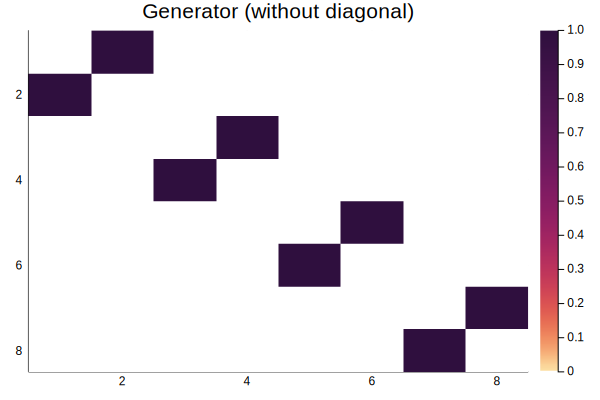

In [21]:
hm(qs[1]-Diagonal(qs[1]), title="Generator (without diagonal)")

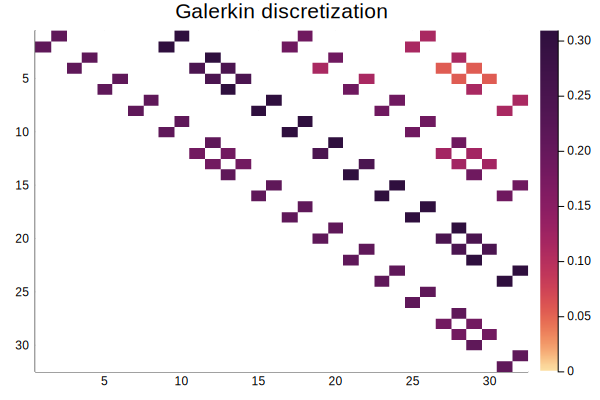

In [23]:
hm(g, color=cg, title="Galerkin discretization") |> display
savefig("barrier_galerkin.pdf")

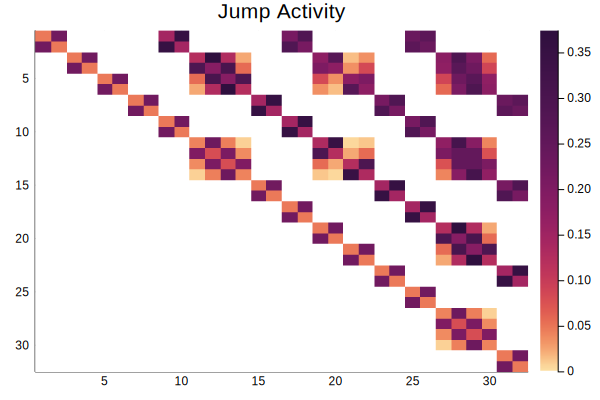

In [24]:
E = EAMC.jumpactivity(g)
hm(E, title="Jump Activity") |> display
savefig("barrier_activity.pdf")

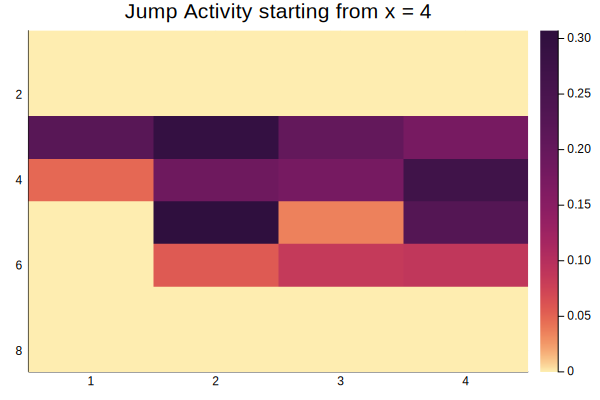

In [7]:
f0=zeros(nx)
x0 = 4
f0[x0] = 1
act = EAMC.project_jumpactivity(E, f0)
hm(act, title="Jump Activity starting from x = $x0")

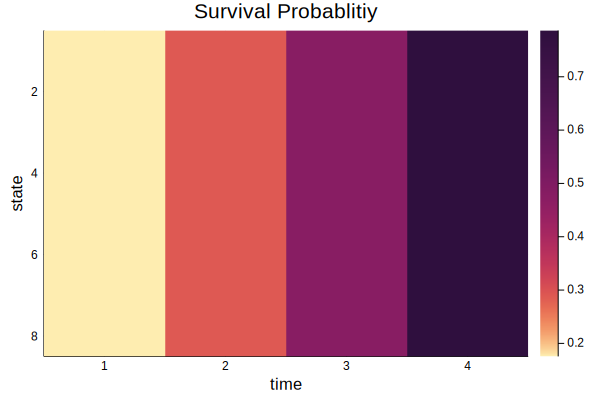

In [8]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="Survival Probablitiy", xlabel="time", ylabel="state")

In [9]:
Pf = EAMC.perronfrobenius(g, qs, ts)

8×8 Adjoint{Float64,Array{Float64,2}}:
 0.473805  0.48594   0.0       0.0       …  0.0       0.0       0.0     
 0.48594   0.473805  0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.405423  0.359307     0.069064  0.0       0.0     
 0.0       0.0       0.386871  0.414551     0.149238  0.0       0.0     
 0.0       0.0       0.149238  0.188537     0.386871  0.0       0.0     
 0.0       0.0       0.069064  0.125952  …  0.405423  0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.473805  0.48594 
 0.0       0.0       0.0       0.0          0.0       0.48594   0.473805

In [10]:
Pf_exp = exp(qs[1]|>collect)'

8×8 Adjoint{Float64,Array{Float64,2}}:
 0.567668  0.432332  0.0       0.0       …  0.0       0.0       0.0     
 0.432332  0.567668  0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.567668  0.432332     0.0       0.0       0.0     
 0.0       0.0       0.432332  0.567668     0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          0.432332  0.0       0.0     
 0.0       0.0       0.0       0.0       …  0.567668  0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.567668  0.432332
 0.0       0.0       0.0       0.0          0.0       0.432332  0.567668

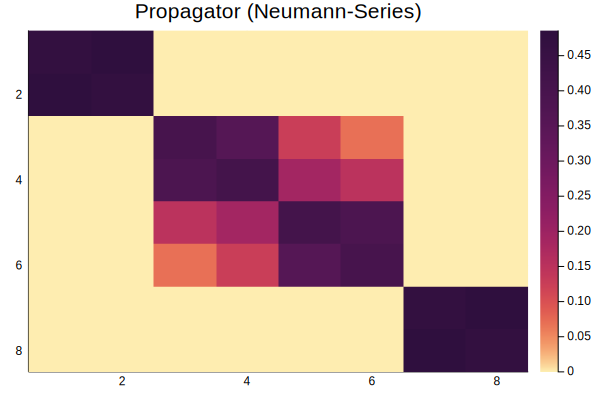

In [11]:
hm(Pf, title="Propagator (Neumann-Series)")

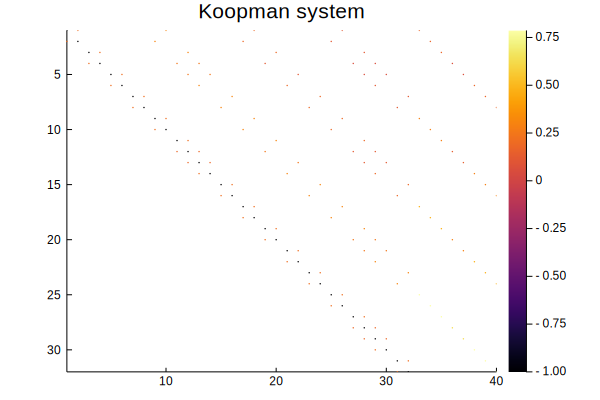

In [12]:
A = EAMC.koopman_system(g, nx)
spy(A, title="Koopman system")

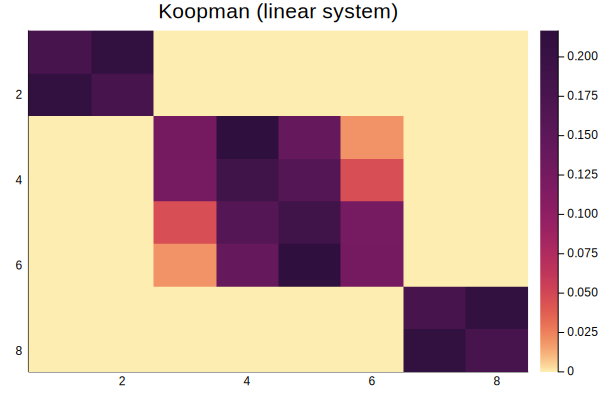

In [13]:
K = EAMC.koopman(g, nx)
hm(K, title="Koopman (linear system)")

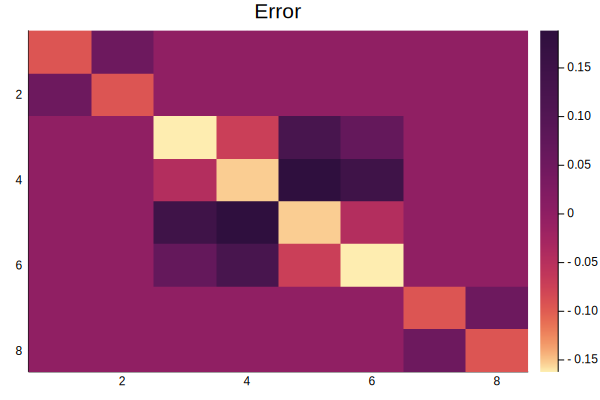

In [14]:
hm(Pf - Pf_exp, title="Error")

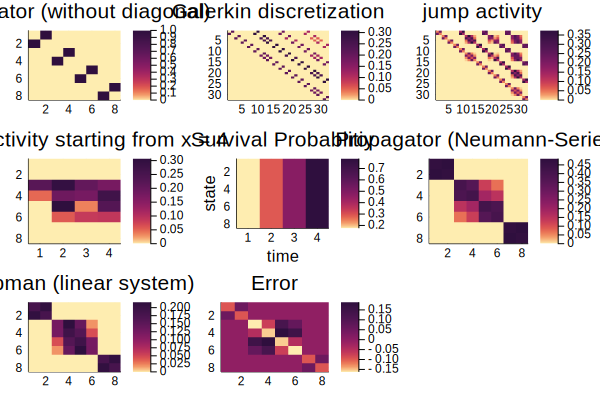

In [15]:
plot(myplots...)